In [1]:
# Importações

import nltk

from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_auc_score,
    confusion_matrix
)

import pandas as pd
import numpy as np

from nltk.corpus import stopwords

import re

# Cross validate

from sklearn.model_selection import cross_validate, cross_val_score

# Modelos

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

# Similaridade de Cossenos
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance

In [2]:
# Importação do Dataframe contendo títulos de notícias relacionadas a saúde.

dataframe = pd.read_csv('dados/combined_df.zip')

display(dataframe)

,title,link,date,Site,noticia_falsa,corpo_texto
0,Ministro alemão quer disponibilizar testes cov...,https://g1.globo.com/mundo/noticia/2020/07/05/...,05/07/2020 08h51,NaN,1,o ministrar interior alemanha horst seehofer o...
1,'Minions 2' ganha nova data 2021 após adiament...,https://entretenimento.uol.com.br/noticias/red...,01/04/2020 14h20,NaN,1,minions o origem gru datar chegar o cinema o u...
2,Atividade física interfere prognóstico casos g...,https://www.uol.com.br/vivabem/noticias/redaca...,26/01/2021 09h13,NaN,1,estudo recente sugerir o prático regular exerc...
3,Pesquisa brasileira usou doses letais matar pa...,https://projetocomprova.com.br/publicações/pes...,2020/04/24,NaN,0,publicação rede social pesquisar brasileiro ac...
4,"Álcool gel, luvas máscaras roubados posto saúd...",https://noticias.uol.com.br/saude/ultimas-noti...,17/03/2020 21h03,NaN,1,postar saudar goiânia bairro conjuntar vero cr...
...,...,...,...,...,...,...
5119,monitoramento eventosacesse monitoramento even...,https://www.gov.br/saude/pt-br/vacinacao/esavi...,Data não disponível,gov.br saude,1,"['monitoramento', 'eventos', 'ministério', 'sa..."
5120,"SP anuncia relaxamento isolamento 11 maio, omi...",https://noticias.uol.com.br/videos/2020/04/22/...,22/04/2020 14h54,NaN,1,patrício ellen secretário desenvolvimento econ...
5121,vídeo vítimas covid descendo amarrados necroté...,http://www.e-farsas.com/o-video-de-vitimas-do-...,Data não disponível,E-Farsas (Falso),0,"['vídeo', 'vítimas', 'covid', 'descendo', 'ama..."
5122,Termômetro digital testa lança raio destruidor...,https://www.boatos.org/saude/termometro-na-tes...,18/08/2020,NaN,0,“ raiar testo destruidor glândula pineal cuida...


In [3]:
# Cria dataframe para processamento
df = dataframe.copy()
df_sorted = df.sort_values(by='noticia_falsa').reset_index(drop=True)

# Transformar a coluna título em string
df_sorted['title'] = df_sorted['title'].astype(str)

In [4]:
### Filtrando notícias com valores 0 e 1
noticias_falsa_0 = df_sorted[df_sorted['noticia_falsa'] == 0]
noticias_falsa_1 = df_sorted[df_sorted['noticia_falsa'] == 1] # Aqui estão representadas as notícias verdadeiras

### Selecionar, aleatoriamente, 1000 notícias com valores 0 e 1500 com valores 1
amostra_0 = noticias_falsa_0.sample(n=1000, random_state=42)
amostra_1 = noticias_falsa_1.sample(n=1500, random_state=42)

# Criando um novo dataframe com estas notícias
novo_df = pd.concat([amostra_0, amostra_1])

# Resetando o index
novo_df = novo_df.sample(frac=1, random_state=24).reset_index(drop=True)

display(novo_df)

,title,link,date,Site,noticia_falsa,corpo_texto
0,"#BoasNotícias30/3: Cidade imune, toneladas fei...",https://www.uol.com.br/ecoa/ultimas-noticias/2...,30/03/2020 19h18,NaN,1,o discursar o preocupação pessoa sustentar dur...
1,gov.br,https://www.gov.br/saude/pt-br/vacinacao/esavi...,Data não disponível,gov.br saude,1,"['erro', 'carregar', 'texto']"
2,sistema saúde pública segue filosofia medicina...,https://medicospelavidacovid19.com.br/opiniao/...,Data não disponível,Médicos Pela Vida,0,"['sistema', 'saúde', 'pública', 'segue', 'filo..."
3,"portaria nº 2.992, 26 dezembro 2012",https://www.gov.br/saude/pt-br/vacinacao/legis...,Data não disponível,gov.br saude,1,"['404', 'not', 'found', 'not', 'found', 'the',..."
4,Serrana (SP) aumento mortes Covid-19 causa vac...,https://www.boatos.org/saude/serrana-sp-aument...,05/04/2021,NaN,0,cidade serrana-sp escolhido doria e dimas cova...
...,...,...,...,...,...,...
2495,Gabbardo reforça advertência contra cloroquina...,https://noticias.uol.com.br/saude/ultimas-noti...,08/07/2020 14h10,NaN,1,o centrar contingência coronavírus paulo volta...
2496,Prefeito São Paulo proibiu hidroxicloroquina u...,https://projetocomprova.com.br/publicações/pre...,2020/06/26,NaN,0,o o contrário afirmar publicação rede social o...
2497,Amapá pode receber 4 profissionais Programa Ma...,https://www.gov.br/saude/pt-br/assuntos/notici...,09/03/2021 19h03,NaN,1,aprimorar o assistência unidade básico saudar ...
2498,www.medicospelavidacovid19.com.br/jornada,https://www.medicospelavidacovid19.com.br/jornada,Data não disponível,Médicos Pela Vida,0,"['página', 'encontrada', 'mpv', 'skip', 'to', ..."


In [5]:
# Agora, separaremos uma porção para validação com dados externos

### Separar as notícias restantes
restantes_0 = noticias_falsa_0.drop(amostra_0.index)
restantes_1 = noticias_falsa_1.drop(amostra_1.index)

# Selecionar 449 notícias restantes com valor 0 e 800 com valor 1
amostra_0_restante = restantes_0
amostra_1_restante = restantes_1.sample(n=800, random_state=42)

# Criar um novo dataframe
segundo_df = pd.concat([amostra_0_restante, amostra_1_restante])

# Bagunçar o df
segundo_df = segundo_df.sample(frac=1, random_state=48).reset_index(drop=True)

display(segundo_df)

,title,link,date,Site,noticia_falsa,corpo_texto
0,monitoramento rápido coberturas vacinais pós-c...,https://www.gov.br/saude/pt-br/vacinacao/publi...,Data não disponível,gov.br saude,1,"['monitoramento', 'rápido', 'coberturas', 'vac..."
1,Opas vê risco faltar insumos intubação hospita...,https://noticias.uol.com.br/ultimas-noticias/a...,31/03/2021 13h05Atualizada em 31/03/2021 14h00,NaN,1,diretora organização pan-americana saudar opar...
2,"PF mira fraudes contratos R$ 33,7 mi combate c...",https://noticias.uol.com.br/ultimas-noticias/a...,12/01/2021 12h48,NaN,1,o pf polícia federal piauí deflagrar hoje o op...
3,Ministério Saúde identificou 204 casos novas v...,https://noticias.uol.com.br/saude/ultimas-noti...,23/02/2021 15h59,NaN,1,o secretariar vigilância saudar ligar o o mini...
4,Venezuela recebe 73 toneladas ajuda europeia c...,https://noticias.uol.com.br/ultimas-noticias/a...,22/08/2020 16h11,NaN,1,caracas ago afp o venezuela receber n sábado t...
...,...,...,...,...,...,...
1239,Donos mandam trocar fechaduras igreja após pas...,https://noticias.uol.com.br/internacional/ulti...,07/04/2020 17h13,NaN,1,pastor cidade lodi califórnio planejar o reali...
1240,Coronavírus: Polônia eleições presidenciais in...,https://noticias.uol.com.br/ultimas-noticias/a...,06/04/2020 21h09,NaN,1,atual pandemia coronavírus o parlamentar polôn...
1241,ofícios circulares,https://www.gov.br/saude/pt-br/assuntos/covid-...,Data não disponível,gov.br saude,1,"['ofícios', 'circulares', 'ministério', 'saúde..."
1242,É #FAKE escovas dentes pacientes Covid-19 pode...,https://g1.globo.com/fato-ou-fake/coronavirus/...,03/12/2020,NaN,0,circular rede social o escovar dentar o covid-...


In [6]:
# Checar os títulos únicos em cada Dataframe

titulos_novo_df = set(novo_df['title'].unique())
titulos_segundo_df = set(segundo_df['title'].unique())

# Vendo se há títulos repetidos

titulos_repetidos = titulos_novo_df.intersection(titulos_segundo_df)

print(f"Títulos repetidos: {titulos_repetidos}")

# Remover do 'segundo_df' os títulos repetidos

segundo_df_filtrado = segundo_df[~segundo_df['title'].isin(titulos_novo_df)]

segundo_df_filtrado = segundo_df_filtrado.reset_index(drop=True)

display(segundo_df_filtrado)

Títulos repetidos: {'Verificações AFP português sobre novo coronavírus', 'Japoneses descobrem nanopartículas mRNA vacina ficam corpo pessoas podem causar infertilidade #boato', 'Médico usa dados enganosos sugerir conspiração sobre covid-19', 'www.medicospelavidacovid19.com.br/jornada', 'TCU afirma 50% óbitos registrados Covid-19 Covid-19 #boato', 'calendário técnico nacional vacinação', 'calendário vacinação', 'Biden reverte ato Trump volta impor restrições viagens Brasil', 'Jorge Aragão internado UTI Covid-19', 'Mercados abastecidos preparados alta demanda, diz associação', 'Post confunde comparar letalidade covid-19 outras doenças', 'compartilhe whatsapp', 'baixar pdf', 'Relação vibração alta covid-19 comprovação científica', 'gov.br', '2', 'rede frio', 'cobertura vacinal', 'Não evidências científicas sobre necessidade trocar escova dental após caso covid-19', 'Veja #FATO #FAKE declarações médica Nise Yamaguchi CPI Covid', 'vacinação', 'editoriais', 'estudos', 'vídeos', 'covid-19', '

,title,link,date,Site,noticia_falsa,corpo_texto
0,monitoramento rápido coberturas vacinais pós-c...,https://www.gov.br/saude/pt-br/vacinacao/publi...,Data não disponível,gov.br saude,1,"['monitoramento', 'rápido', 'coberturas', 'vac..."
1,Opas vê risco faltar insumos intubação hospita...,https://noticias.uol.com.br/ultimas-noticias/a...,31/03/2021 13h05Atualizada em 31/03/2021 14h00,NaN,1,diretora organização pan-americana saudar opar...
2,"PF mira fraudes contratos R$ 33,7 mi combate c...",https://noticias.uol.com.br/ultimas-noticias/a...,12/01/2021 12h48,NaN,1,o pf polícia federal piauí deflagrar hoje o op...
3,Ministério Saúde identificou 204 casos novas v...,https://noticias.uol.com.br/saude/ultimas-noti...,23/02/2021 15h59,NaN,1,o secretariar vigilância saudar ligar o o mini...
4,Venezuela recebe 73 toneladas ajuda europeia c...,https://noticias.uol.com.br/ultimas-noticias/a...,22/08/2020 16h11,NaN,1,caracas ago afp o venezuela receber n sábado t...
...,...,...,...,...,...,...
1199,Donos mandam trocar fechaduras igreja após pas...,https://noticias.uol.com.br/internacional/ulti...,07/04/2020 17h13,NaN,1,pastor cidade lodi califórnio planejar o reali...
1200,Coronavírus: Polônia eleições presidenciais in...,https://noticias.uol.com.br/ultimas-noticias/a...,06/04/2020 21h09,NaN,1,atual pandemia coronavírus o parlamentar polôn...
1201,ofícios circulares,https://www.gov.br/saude/pt-br/assuntos/covid-...,Data não disponível,gov.br saude,1,"['ofícios', 'circulares', 'ministério', 'saúde..."
1202,É #FAKE escovas dentes pacientes Covid-19 pode...,https://g1.globo.com/fato-ou-fake/coronavirus/...,03/12/2020,NaN,0,circular rede social o escovar dentar o covid-...


In [7]:
# Variáveis para padronização/configuração

scores = ['accuracy', 'precision', 'roc_auc']
usar_links = False

In [8]:
# Checar se há títulos vazios
non_empty_titles = novo_df['title'].apply(lambda x: len(x.strip()) > 0)
non_empty_links = novo_df['link'].apply(lambda x: len(x.strip()) > 0)

# Checar o resultado
print(non_empty_titles.head())
print("Há documentos vazios?", not non_empty_titles.all())
print("Há links vazios?", not non_empty_links.all())
print("Número de documentos vazios:", (~non_empty_titles).sum())
print("Número de links vazios:", (~non_empty_links).sum())

0    True
1    True
2    True
3    True
4    True
Name: title, dtype: bool
Há documentos vazios? False
Há links vazios? False
Número de documentos vazios: 0
Número de links vazios: 0


In [9]:
# Iniciar o processo de TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Nesta célula, será aplicado o TF-IDF aos títulos das notícias, caso não haja nenhum vazio
temp_tit = novo_df['title'].tolist()
if non_empty_titles.all():
    titles_tfidf = tfidf_vectorizer.fit_transform(temp_tit)
    print('TF-IDF aplicado com sucesso.')
    tfidf = titles_tfidf
else:
    print('Há documentos vazios ou apenas stop words.')

TF-IDF aplicado com sucesso.


In [10]:
def split_and_clean(link):
# Dividir o link por '/', '-', '%', '.', e ':'
    words = re.split(r'[/\-\%\.\:\_]', link)
    # Remover palavras indesejadas, stopwords e letras isoladas, mantendo acentos
    unwanted = {'https', 'www', 'com', 'br', 'pt', 'html', 'htm', 'ghtml', 'php'}
    cleaned_words = [
    word for word in words
    if not any(unwanted_word in word.lower() for unwanted_word in unwanted)
    and len(word) > 1
    ]
    return cleaned_words

if usar_links:

    # Tratando os links
    df['processed_links'] = df['link'].apply(split_and_clean)

    # TF-IDF para os combinação título e link
    temp_link = [' '.join(i) for i in df['processed_links']]
    temp_tit_link = [' '.join(list(a)) for a in zip(temp_tit, temp_link)]
    print(temp_tit_link)
    if non_empty_links.all():
        tit_link_tfidf = tfidf_vectorizer.fit_transform(temp_tit_link)
        print('TF-IDF aplicado com sucesso.')
        tfidf = tit_link_tfidf
    else:
        print('Há items vazios ou apenas stop words.')

In [11]:
# Criação de vetores
X = tfidf
y = novo_df['noticia_falsa']

titulos = novo_df['title'].tolist()

print("Dimensões de X:", X.shape)
print("Dimensões de y:", y.shape)

Dimensões de X: (2500, 5829)
Dimensões de y: (2500,)


## Modelos de Classificação
### Árvore de Decisão

In [12]:
# Padronizando scores para todos os modelos.

scores = ['accuracy', 'precision', 'roc_auc']

In [13]:
# Cria modelo
modelo_ad = DecisionTreeClassifier()
modelo_ad

# Validação cruzada
resultados_ad = cross_validate(modelo_ad, X, y, scoring=scores)

acc_ad = resultados_ad['test_accuracy'].mean()
prec_ad = resultados_ad['test_precision'].mean()
rocauc_ad = resultados_ad['test_roc_auc'].mean()
print(f'Acurácia: {acc_ad:.3f}\nPrecisão: {prec_ad:.3f}\nROC-AUC: {rocauc_ad:.3f}')

Acurácia: 0.802
Precisão: 0.859
ROC-AUC: 0.830


### Floresta Aleatória

In [14]:
# Cria modelo
modelo_rf = RandomForestClassifier()
modelo_rf

# Validação cruzada
resultados_rf = cross_validate(modelo_rf, X, y, scoring=scores)

acc_rf = resultados_rf['test_accuracy'].mean()
prec_rf = resultados_rf['test_precision'].mean()
rocauc_rf = resultados_rf['test_roc_auc'].mean()
print(f'Acurácia: {acc_rf:.3f}\nPrecisão: {prec_rf:.3f}\nROC-AUC: {rocauc_rf:.3f}')

Acurácia: 0.845
Precisão: 0.865
ROC-AUC: 0.918


### Modelo Regressão Logística

In [15]:
# Cria modelo
modelo_lr = LogisticRegression()
modelo_lr

# Validação cruzada
resultados_lr = cross_validate(modelo_lr, X, y, scoring=scores)

acc_lr = resultados_lr['test_accuracy'].mean()
prec_lr = resultados_lr['test_precision'].mean()
rocauc_lr = resultados_lr['test_roc_auc'].mean()
print(f'Acurácia: {acc_lr:.3f}\nPrecisão: {prec_lr:.3f}\nROC-AUC: {rocauc_lr:.3f}')

Acurácia: 0.838
Precisão: 0.796
ROC-AUC: 0.946


### SVC

In [16]:
# Parâmetros
C = 77
kernel = 'rbf'
gamma = 0.01

# Cria modelo
modelo_svm = svm.SVC(C=C, kernel=kernel, gamma=gamma)

# Validação cruzada
resultados_svm = cross_validate(modelo_svm, X, y, scoring=scores)

acc_svm = resultados_svm['test_accuracy'].mean()
prec_svm = resultados_svm['test_precision'].mean()
rocauc_svm = resultados_svm['test_roc_auc'].mean()
print(f'Acurácia: {acc_svm:.3f}\nPrecisão: {prec_svm:.3f}\nROC-AUC: {rocauc_svm:.3f}')

Acurácia: 0.889
Precisão: 0.873
ROC-AUC: 0.952


## Definindo funções

In [17]:
stop_words = set(stopwords.words('portuguese'))

def trata_padrao(titulo, usar_links=False, link=None):
    '''
    Função para padronizar o tratamento dos títulos.

    Args:
    titulo (str) = título da notícia
    usar_links (bool) = usar ou não o link
    link (str) = link da notícia
    '''

    # Pré-processamento do titulo

    titulo = str(titulo).lower()
    titulo = nltk.word_tokenize(titulo)
    titulo = [word for word in titulo if word not in stop_words]
    titulo = [' '.join(titulo)]
    temp_tit = titulo

    # se usar link, pre processar link
    if usar_links:
        link = [split_and_clean(link)]
        temp_link = [' '.join(i) for i in link]
        print(temp_tit,temp_link)
        temp_tit_link = [' '.join(list(a)) for a in zip(temp_tit, temp_link)]
        processed = temp_tit_link
    else:
        processed = titulo

    return processed

In [18]:
# Define modelos para teste
modelos = [modelo_ad, modelo_rf, modelo_lr, modelo_svm]

# Treina modelos com todos os dados
for modelo in modelos:
    modelo.fit(X, y)

# Função para predizer novos títulos
def predict_title(titulo):
    preprocessed_title = trata_padrao(titulo)

    tfidf_vector = tfidf_vectorizer.transform(preprocessed_title)
    preds = dict()

    for modelo in modelos:
        preds[modelo] = modelo.predict(tfidf_vector)

    return preds

In [19]:
def comparar(df):
    '''
    Função para comparar predições de diferentes modelos com o target

    Args:
        df (pandas.df): dataframe com coluna '1' sendo os títulos/corpus, e '2' com o target/label
        
    Returns:
        list: Uma lista contendo 4 listas (uma para cada modelo: Decision Tree, Random Forest, Logistic Regression, SVC)
    '''
    DT, RF, LR, SVC = [], [], [], []
    for index, row in df.iterrows():
        text = row[0]
        target = row[1]
        pred = predict_title(text)
        pred['Target'] = [target]
        
        # Guardar as previsões em suas respectivas listas
        keys = [i for i in pred.keys()]
        DT.append(pred[keys[0]][0])
        RF.append(pred[keys[1]][0])
        LR.append(pred[keys[2]][0])
        SVC.append(pred[keys[3]][0])
        
        print(f'Notícia: {text}\n')
        for i in pred:
            print("\t{}\t{}".format(i, pred[i]))
        print('-----------------------------------------------------')
        print()
        
    return [DT, RF, LR, SVC]

### Teste com dados que foram separados para validação

In [20]:
segundo_df_filtrado = segundo_df_filtrado[['title', 'noticia_falsa']]

#segundo_df.columns = ['', '']

display(segundo_df_filtrado)

,title,noticia_falsa
0,monitoramento rápido coberturas vacinais pós-c...,1
1,Opas vê risco faltar insumos intubação hospita...,1
2,"PF mira fraudes contratos R$ 33,7 mi combate c...",1
3,Ministério Saúde identificou 204 casos novas v...,1
4,Venezuela recebe 73 toneladas ajuda europeia c...,1
...,...,...
1199,Donos mandam trocar fechaduras igreja após pas...,1
1200,Coronavírus: Polônia eleições presidenciais in...,1
1201,ofícios circulares,1
1202,É #FAKE escovas dentes pacientes Covid-19 pode...,0


In [21]:
predictions = comparar(segundo_df_filtrado)

/tmp/ipykernel_149997/3291409112.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[0]
/tmp/ipykernel_149997/3291409112.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = row[1]


Notícia: monitoramento rápido coberturas vacinais pós-campanhas vacinação brasil: 2008, 2011 2012

	DecisionTreeClassifier()	[1]
	RandomForestClassifier()	[1]
	LogisticRegression()	[1]
	SVC(C=77, gamma=0.01)	[1]
	Target	[1]
-----------------------------------------------------

Notícia: Opas vê risco faltar insumos intubação hospitais brasileiros

	DecisionTreeClassifier()	[1]
	RandomForestClassifier()	[1]
	LogisticRegression()	[1]
	SVC(C=77, gamma=0.01)	[1]
	Target	[1]
-----------------------------------------------------

Notícia: PF mira fraudes contratos R$ 33,7 mi combate coronavírus PI

	DecisionTreeClassifier()	[1]
	RandomForestClassifier()	[1]
	LogisticRegression()	[1]
	SVC(C=77, gamma=0.01)	[1]
	Target	[1]
-----------------------------------------------------

Notícia: Ministério Saúde identificou 204 casos novas variantes Brasil

	DecisionTreeClassifier()	[1]
	RandomForestClassifier()	[1]
	LogisticRegression()	[1]
	SVC(C=77, gamma=0.01)	[1]
	Target	[1]
-----------------------

In [22]:
# Calcula score de cada método para df externo
target = segundo_df_filtrado['noticia_falsa'].tolist()

acc_dt_e = cross_val_score(modelo_ad, X, y, scoring='accuracy')
acc_rf_e = cross_val_score(modelo_rf, X, y, scoring='accuracy')
acc_lr_e = cross_val_score(modelo_lr, X, y, scoring='accuracy')
acc_svc_e = cross_val_score(modelo_svm, X, y, scoring='accuracy')

prec_dt_e = cross_val_score(modelo_ad, X, y, scoring='precision')
prec_rf_e = cross_val_score(modelo_rf, X, y, scoring='precision')
prec_lr_e = cross_val_score(modelo_lr, X, y, scoring='precision')
prec_svc_e = cross_val_score(modelo_svm, X, y, scoring='precision')

acc_dt_mean = acc_dt_e.mean()
acc_rf_mean = acc_rf_e.mean()
acc_lr_mean = acc_lr_e.mean()
acc_svc_mean = acc_svc_e.mean()

acc_dt_std = acc_dt_e.std()
acc_rf_std = acc_rf_e.std()
acc_lr_std = acc_lr_e.std()
acc_svc_std = acc_svc_e.std()

prec_dt_mean = prec_dt_e.mean()
prec_rf_mean = prec_rf_e.mean()
prec_lr_mean = prec_lr_e.mean()
prec_svc_mean = prec_svc_e.mean()

prec_dt_std = prec_dt_e.std()
prec_rf_std = prec_rf_e.std()
prec_lr_std = prec_lr_e.std()
prec_svc_std = prec_svc_e.std()

print('---- Decision Tree ----')
print(f'Acurácia: {acc_dt_mean:.3f} ± {acc_dt_std:.3f}\nPrecisão: {prec_dt_mean:.3f} ± {prec_dt_std:.3f}')
print()
print('---- Random Forest ----')
print(f'Acurácia: {acc_rf_mean:.3f} ± {acc_rf_std:.3f}\nPrecisão: {prec_rf_mean:.3f} ± {prec_rf_std:.3f}')
print()
print('---- Linear Regression ----')
print(f'Acurácia: {acc_lr_mean:.3f} ± {acc_lr_std:.3f}\nPrecisão: {prec_lr_mean:.3f} ± {acc_lr_std:.3f}')
print()
print('---- SVC ----')
print(f'Acurácia: {acc_svc_mean:.3f} ± {acc_svc_std:.3f}\nPrecisão: {prec_svc_mean:.3f} ± {acc_svc_std:.3f}')
print()

---- Decision Tree ----
Acurácia: 0.817 ± 0.015
Precisão: 0.864 ± 0.013

---- Random Forest ----
Acurácia: 0.846 ± 0.015
Precisão: 0.859 ± 0.022

---- Linear Regression ----
Acurácia: 0.838 ± 0.011
Precisão: 0.796 ± 0.011

---- SVC ----
Acurácia: 0.889 ± 0.016
Precisão: 0.873 ± 0.016



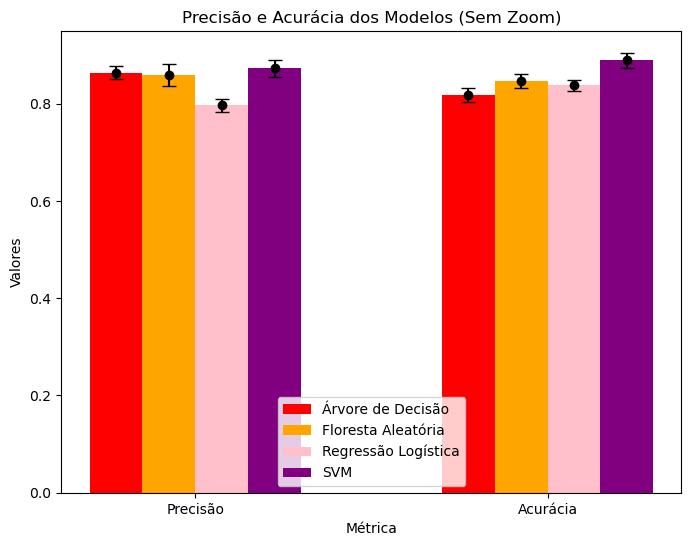

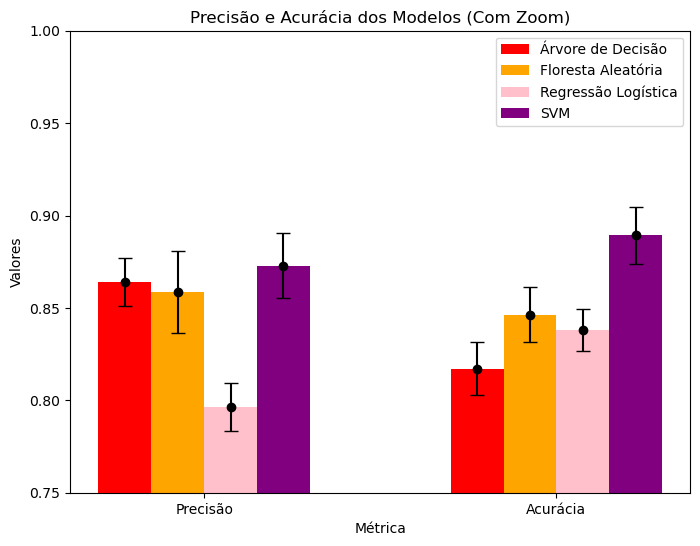

In [23]:
# Definindo os dados
accuracy_list = [acc_dt_mean, acc_rf_mean, acc_lr_mean, acc_svc_mean]
precision_list = [prec_dt_mean, prec_rf_mean, prec_lr_mean, prec_svc_mean]
acc_std_list = [acc_dt_std, acc_rf_std, acc_lr_std, acc_svc_std]
prec_std_list = [prec_dt_std, prec_rf_std, prec_lr_std, prec_svc_std]
model_labels = ['Árvore de Decisão', 'Floresta Aleatória', 'Regressão Logística', 'SVM']
colors = ['red', 'orange', 'pink', 'purple']

# Posições das barras para os grupos
x = np.arange(2)  # Um ponto para "Precisão" e outro para "Acurácia"
width = 0.15      # Largura das barras

# Criando o gráfico sem zoom
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(len(model_labels)):
    # Precisão
    ax.bar(x[0] + i * width - (1.5 * width), precision_list[i], width, label=model_labels[i], color=colors[i])
    ax.errorbar(x[0] + i * width - (1.5 * width), precision_list[i], yerr=prec_std_list[i], fmt='o', color='black', capsize=5)
    # Acurácia
    ax.bar(x[1] + i * width - (1.5 * width), accuracy_list[i], width, color=colors[i])
    ax.errorbar(x[1] + i * width - (1.5 * width), accuracy_list[i], yerr=acc_std_list[i], fmt='o', color='black', capsize=5)

# Configurando os rótulos e título
ax.set_xlabel('Métrica')
ax.set_ylabel('Valores')
ax.set_title('Precisão e Acurácia dos Modelos (Sem Zoom)')
ax.set_xticks(x)
ax.set_xticklabels(['Precisão', 'Acurácia'])
ax.legend()

# Exibindo o gráfico sem zoom
plt.show()

# Criando o gráfico com zoom
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(len(model_labels)):
    # Precisão
    ax.bar(x[0] + i * width - (1.5 * width), precision_list[i], width, label=model_labels[i], color=colors[i])
    ax.errorbar(x[0] + i * width - (1.5 * width), precision_list[i], yerr=prec_std_list[i], fmt='o', color='black', capsize=5)
    # Acurácia
    ax.bar(x[1] + i * width - (1.5 * width), accuracy_list[i], width, color=colors[i])
    ax.errorbar(x[1] + i * width - (1.5 * width), accuracy_list[i], yerr=acc_std_list[i], fmt='o', color='black', capsize=5)

# Configurando os rótulos e título
ax.set_xlabel('Métrica')
ax.set_ylabel('Valores')
ax.set_title('Precisão e Acurácia dos Modelos (Com Zoom)')
ax.set_xticks(x)
ax.set_xticklabels(['Precisão', 'Acurácia'])
ax.legend()

# Definindo o limite do eixo y para dar o "zoom"
plt.ylim(0.75, 1)

# Exibindo o gráfico com zoom
plt.show()

### Similaridade de Cosseno

In [24]:
%matplotlib inline

In [25]:
# Função de similaridade de cosseno entre dois textos
def cosine_distance_countvectorizer_method(s1, s2):
    allsentences = [s1, s2]
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()

    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    return round((1 - cosine) * 100, 2)  # Similaridade em %

In [26]:
# Função principal que faz tudo: calcula similaridade, chama predict_title e gera gráfico
def process_title_and_predict(combined_df, palavra_especifica):
    similaridades = []

    # Calculando a similaridade da palavra específica com todas as outras
    for i, title in enumerate(combined_df['title']):
        if title != palavra_especifica:  # Não compara consigo mesma
            similaridade = cosine_distance_countvectorizer_method(palavra_especifica, title)
            noticia_falsa_status = combined_df.iloc[i]['noticia_falsa']  # Valor de 'noticia_falsa' correspondente
            similaridades.append((title, similaridade, noticia_falsa_status))

    # Ordenando as 10 palavras mais semelhantes
    similaridades_ordenadas = sorted(similaridades, key=lambda x: x[1], reverse=True)[:10]

    # Exibindo as 10 palavras mais semelhantes e o status de 'noticia_falsa'
    print(f"\nAs 10 títulos mais semelhantes a '{palavra_especifica}':")
    for title, sim, noticia_falsa in similaridades_ordenadas:
        print(f"{title} - Similaridade: {sim}% - Notícia Falsa: {noticia_falsa}")

    # Gráfico de barras para similaridades
    titles = [f'{title} - {noticia_falsa}' for title, sim, noticia_falsa in similaridades_ordenadas]
    sims = [sim for title, sim, noticia_falsa in similaridades_ordenadas]

    # Limpando o gráfico anterior
    plt.clf()

    # Plotando o gráfico
    plt.barh(titles, sims, color='skyblue')
    plt.xlabel('Similaridade (%)')
    plt.ylabel('Títulos')
    plt.title(f'Similaridade com: {palavra_especifica}')
    plt.gca().invert_yaxis()  # Inverte a ordem dos títulos no eixo Y para ficar mais intuitivo
    
    # Exibir o gráfico no notebook ou ambiente gráfico
    plt.show()

    # Chamada da função de predição (predict_title)
    print(f"\nPredição para o título: '{palavra_especifica}'")
    resultado_predicao = predict_title(palavra_especifica)
    print("Resultado da Predição:", resultado_predicao)

In [27]:
palavra_especifica = input("Digite o título para encontrar similaridades e prever: ")

/home/ABTLUS/alice220049/.local/lib/python3.10/site-packages/scipy/spatial/distance.py:647: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)



As 10 títulos mais semelhantes a 'Vacina em gotinhas da poliomielite é substituída por dose injetável; entenda mudanças':
Segunda dose CoronaVac relacionada taxa eficácia vacina - Similaridade: 22.79% - Notícia Falsa: 0
vacina covid - Similaridade: 21.32% - Notícia Falsa: 0
vacina hepatite - Similaridade: 21.32% - Notícia Falsa: 0
EUA: Cerca 60% 65 anos receberam menos dose vacina - Similaridade: 20.1% - Notícia Falsa: 1
Joe Biden recebe 1ª dose vacina contra covid-19 - Similaridade: 20.1% - Notícia Falsa: 1
Nova York quer dar dose única vacina turistas pontos famosos - Similaridade: 19.07% - Notícia Falsa: 1
Vacina Oxford reduz transmissão coronavírus garante eficácia 76% primeira dose - Similaridade: 19.07% - Notícia Falsa: 1
Saúde alerta 1,5 mi pessoas deixaram tomar 2ª dose vacina contra Covid - Similaridade: 18.18% - Notícia Falsa: 1
Brasil aplicou menos dose vacina 6,43 milhões, aponta consórcio veículos imprensa - Similaridade: 18.18% - Notícia Falsa: 1
Brasil aplicou menos dos

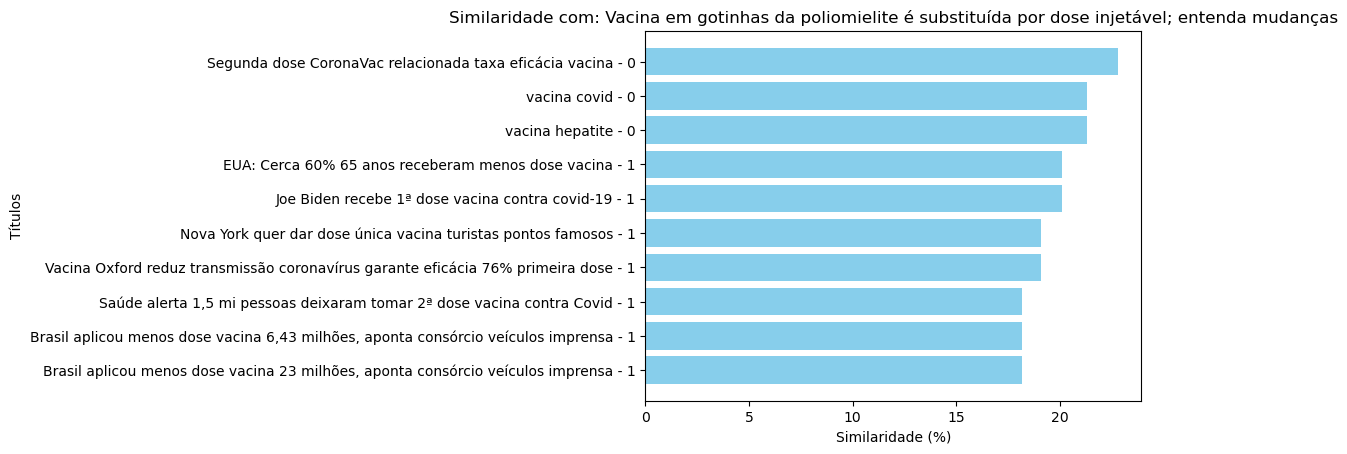


Predição para o título: 'Vacina em gotinhas da poliomielite é substituída por dose injetável; entenda mudanças'
Resultado da Predição: {DecisionTreeClassifier(): array([0]), RandomForestClassifier(): array([1]), LogisticRegression(): array([1]), SVC(C=77, gamma=0.01): array([1])}


In [28]:
process_title_and_predict(segundo_df, palavra_especifica)